In [ ]:
import random
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image, ImageOps
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
from sklearn.datasets import fetch_openml
from torch.utils.data import DataLoader
%matplotlib inline
from pycocotools.coco import COCO
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-34-g1ae9194 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.9/78.2 GB disk)


In [ ]:
# Train YOLOv5s on COCO128 for 3 epochs
!python train.py --img 640 --batch 16 --epochs 15 --data coco128.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=coco128.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=15, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-34-g1ae9194 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, d

In [ ]:
!cp -av "/content/drive/MyDrive/IA2022/dataset_basura_deteccion/segmentacion" "/content/data"

'/content/drive/MyDrive/IA2022/dataset_basura_deteccion/segmentacion' -> '/content/data'
'/content/drive/MyDrive/IA2022/dataset_basura_deteccion/segmentacion/labels' -> '/content/data/labels'
'/content/drive/MyDrive/IA2022/dataset_basura_deteccion/segmentacion/labels/papeles' -> '/content/data/labels/papeles'
'/content/drive/MyDrive/IA2022/dataset_basura_deteccion/segmentacion/labels/papeles/polygon' -> '/content/data/labels/papeles/polygon'
'/content/drive/MyDrive/IA2022/dataset_basura_deteccion/segmentacion/labels/papeles/polygon/COCO.json' -> '/content/data/labels/papeles/polygon/COCO.json'
'/content/drive/MyDrive/IA2022/dataset_basura_deteccion/segmentacion/labels/papeles/polygon/VGG.json' -> '/content/data/labels/papeles/polygon/VGG.json'
'/content/drive/MyDrive/IA2022/dataset_basura_deteccion/segmentacion/labels/papeles/yolo_format' -> '/content/data/labels/papeles/yolo_format'
'/content/drive/MyDrive/IA2022/dataset_basura_deteccion/segmentacion/labels/papeles/yolo_format/papel (

In [ ]:
import json
cocofile= open("/content/data/labels/papeles/polygon/COCO.json")
papeles_coco = json.load(cocofile)

In [ ]:
papeles_coco['categories'][0],papeles_coco['images'][0], papeles_coco['annotations'][0]

({'id': 1, 'name': 'papel'},
 {'id': 1, 'width': 800, 'height': 600, 'file_name': 'papel (100).png'},
 {'id': 0,
  'iscrowd': 0,
  'image_id': 1,
  'category_id': 1,
  'segmentation': [[430.8300395256917,
    1.1857707509881423,
    728.4584980237154,
    66.40316205533597,
    798.4189723320158,
    48.616600790513836,
    798.4189723320158,
    558.498023715415,
    409.4861660079051,
    562.0553359683795,
    229.2490118577075,
    556.1264822134387,
    0,
    537.1541501976285,
    1.5810276679841673,
    484.9802371541502,
    16.996047430830018,
    475.49407114624506,
    18.18181818181816,
    456.5217391304348,
    0.395256916996025,
    445.8498023715415,
    0,
    0]],
  'bbox': [0, 0, 798.4189723320158, 562.0553359683795],
  'area': 429008.3425768252})

In [ ]:
image_id=1
coco_data=COCO("/content/data/labels/papeles/polygon/COCO.json")

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [ ]:
img = coco_data.imgs[image_id]
img

{'id': 1, 'width': 800, 'height': 600, 'file_name': 'papel (100).png'}

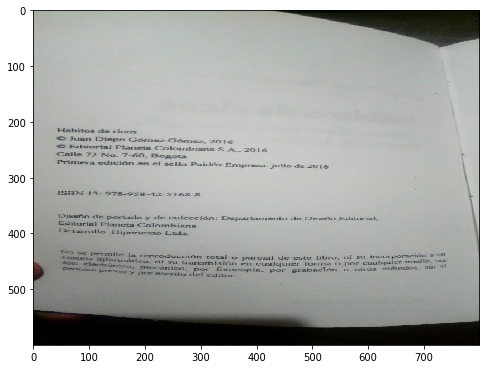

In [ ]:
image = np.array(Image.open("/content/data/images/papeles/"+img['file_name']).convert('RGB'))
plt.imshow(image, interpolation='nearest')
plt.show()

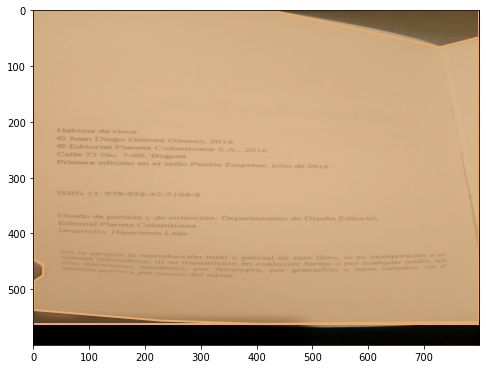

In [ ]:
plt.imshow(image)
cat_ids = coco_data.getCatIds()
anns_ids = coco_data.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco_data.loadAnns(anns_ids)
coco_data.showAnns(anns,draw_bbox=True)

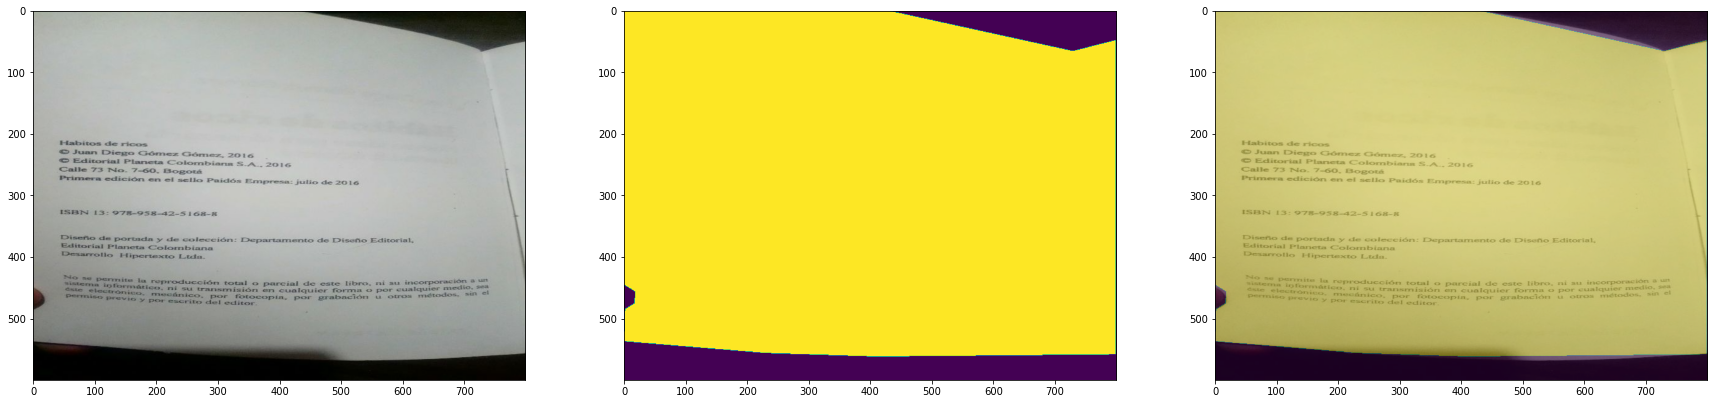

In [ ]:
mask = coco_data.annToMask(anns[0])
for i in range(len(anns)):
    mask += coco_data.annToMask(anns[i])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))

ax1.imshow(image)
ax2.imshow(mask)
ax3.imshow(image)
ax3.imshow(mask, alpha=0.4)
plt.show()
#plt.imshow(mask)

In [ ]:
image.shape

(600, 800, 3)

In [ ]:
mask = coco_data.annToMask(anns[0])
mask.shape, image.max()

((600, 800), 216)

In [ ]:
image.shape

(600, 800, 3)

In [ ]:
"""
Split = utilizamos para formar listas
"""

'\nSplit = utilizamos para formar listas\n'

In [ ]:
#cargamos todas las imagenes de nuestro data
from random import sample
def loadImages(dataset_coco, split=0.1):
    img_test_ = []
    img_train_ = []
    labels_test_ = []
    labels_train_ = []
    data_ = dataset_coco.anns
    test_ids = sample([x for x in range(0,len(coco_data.anns))],int(len(coco_data.anns)*split))
    for i in data_:
        image_id_ = data_[i]['image_id']
        img_ = coco_data.imgs[image_id_]
        image_path="/content/data/images/papeles/"+img_['file_name']
        image_load_ = Image.open(image_path).convert('RGB')

        #normalizamos
        image_ = np.array(image_load_)/255
        anns_=dataset_coco.loadAnns(data_[i]['id'])

        #obtenemos todas las mascaras
        mask_ = dataset_coco.annToMask(anns_[0])
        for ian in range(len(anns_)):
            mask_ += dataset_coco.annToMask(anns_[ian])
        if(i not in test_ids):
            img_train_.append(image_path)
            labels_train_.append(mask_)
        else:
            img_test_.append(image_path)
            labels_test_.append(mask_)
    return np.array(img_train_), np.array(img_test_), np.array(labels_train_), np.array(labels_test_)

In [ ]:
img_train, img_test, labels_train, labels_test = loadImages(coco_data, split=0.1)

In [ ]:
labels_train.shape, labels_test.shape, labels_test.min(), labels_test.max()

((912, 600, 800), (101, 600, 800), 0, 2)

In [ ]:
#retornamos las clases
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, n_classes=3):
    self.X = X
    self.y = y
    self.n_classes = n_classes

  def __len__(self):
    return len(self.X)
  def __getitem__(self, ix):
      image_load = Image.open(self.X[ix]).convert('RGB')
      image = np.array(image_load)/255
      img = image
      img = image.astype(np.float32)

      mask = self.y[ix]    
      img = torch.from_numpy(img).permute(2,0,1)
      mask = (np.arange(self.n_classes) == mask[...,None]).astype(np.float32) 
      return img, torch.from_numpy(mask).permute(2,0,1)

In [ ]:
dataset = {
    'train': Dataset(img_train, labels_train),
    'test': Dataset(img_test, labels_test)
}

len(dataset['train']), len(dataset['test'])

(912, 101)

In [ ]:

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=5, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=10, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([5, 3, 600, 800]), torch.Size([5, 3, 600, 800]))

In [ ]:
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=3):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

In [ ]:
model = UNet()
output = model(torch.randn((5,3,600,800)))
output.shape

torch.Size([5, 3, 600, 800])

In [ ]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious)

In [ ]:
from tqdm import tqdm

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        #ajusta los pesos
        loss.backward()
        #optimiza
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      torch.save(model.state_dict(), 'saved_weights.pt')
    return hist

In [ ]:
model = UNet()
hist = fit(model, dataloader, epochs=5)

test_loss 0.20321 test_iou 0.86967: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s]



Epoch 1/5 loss 0.31381 iou 0.69198 test_loss 0.20321 test_iou 0.86967


test_loss 0.18247 test_iou 0.87638: 100%|██████████| 11/11 [00:05<00:00,  2.13it/s]



Epoch 2/5 loss 0.20386 iou 0.86487 test_loss 0.18247 test_iou 0.87638


test_loss 0.15906 test_iou 0.89221: 100%|██████████| 11/11 [00:05<00:00,  2.13it/s]



Epoch 3/5 loss 0.18623 iou 0.87599 test_loss 0.15906 test_iou 0.89221


test_loss 0.15096 test_iou 0.89706: 100%|██████████| 11/11 [00:05<00:00,  2.12it/s]



Epoch 4/5 loss 0.17472 iou 0.88339 test_loss 0.15096 test_iou 0.89706


test_loss 0.13843 test_iou 0.90708: 100%|██████████| 11/11 [00:05<00:00,  2.09it/s]


Epoch 5/5 loss 0.16581 iou 0.88984 test_loss 0.13843 test_iou 0.90708


In [ ]:
torch.save(model.state_dict(), 'saved_weights.pt')

In [ ]:
scripted_model = torch.jit.script(model.cpu())
scripted_model.save('model.zip')